In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from polire.placement.base import Base
from IPython.display import clear_output

import matplotlib.pyplot as plt
from scipy import stats
from time import time
p = print

from time import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import sys
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import rc

from math import sqrt
SPINE_COLOR = 'gray'
p = print

In [55]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Data

In [56]:
data = pd.read_pickle('../data_and_results/u-air/production/pm25_beijing_best36/linear/linear_df.pickle')
data.head(2)

,station_id,PM25_AQI_value,PM10_AQI_value,NO2_AQI_value,temperature,pressure,humidity,wind,weather,station_name,longitude,latitude
time,,,,,,,,,,,,
2013-11-08 14:26:00,1001,122.0,76.0,30.0,13.0,1020.0,33.0,2.0,3.0,haidianbeibuxinqu,116.173553,40.09068
2013-11-08 14:26:00,1002,90.0,68.0,16.0,0.0,1021.0,75.0,2.0,3.0,haidianbeijingzhiwuyuan,116.205311,40.00395


In [57]:
global_all_stations = data.station_id.unique()
p(global_all_stations)

[1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036]


### Train, pool, test splits

In [58]:
from sklearn.cluster import kmeans_plusplus
all_locs = data[['longitude', 'latitude']].drop_duplicates().values

In [59]:
seed = 0
np.random.seed(seed)
# global_test_stations = global_all_stations[kmeans_plusplus(all_locs, n_clusters=6, random_state=seed)[1]]
global_test_stations = global_all_stations[np.random.choice(len(global_all_stations))]
global_train_pool_stations = np.array(sorted(set(global_all_stations) - set(global_test_stations)))
global_pool_stations, global_train_stations = train_test_split(global_train_pool_stations, test_size=6, random_state=seed)
p('train', len(global_train_stations))
p('test', len(global_test_stations))
p('pool', len(global_pool_stations))

train 6
test 6
pool 24


In [60]:
pd.to_pickle(global_test_stations, 'global_test.station')
pd.to_pickle(global_train_stations, 'global_train.station')

(6, 2) (6, 2) (24, 2)


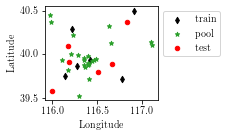

In [61]:
latexify(3.32, 2)
trn_locs = data[data.station_id.isin(global_train_stations)][['longitude', 'latitude']].drop_duplicates().values
tst_locs = data[data.station_id.isin(global_test_stations)][['longitude', 'latitude']].drop_duplicates().values
pool_locs = data[data.station_id.isin(global_pool_stations)][['longitude', 'latitude']].drop_duplicates().values

print(trn_locs.shape, tst_locs.shape, pool_locs.shape)

fig, ax = plt.subplots()
ss = 20
ax.scatter(trn_locs[:,0], trn_locs[:,1], c='black', s=ss, marker='d', label='train')
ax.scatter(pool_locs[:,0], pool_locs[:,1], c='tab:green', s=ss, marker='*', label='pool')
ax.scatter(tst_locs[:,0], tst_locs[:,1], c='red', s=ss, label='test')
ax.legend(bbox_to_anchor=(1,1));
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.tight_layout()
fig.savefig('imgs/tpt'+str(seed)+'.pdf')

### Global config

In [62]:
data.columns

Index(['station_id', 'PM25_AQI_value', 'PM10_AQI_value', 'NO2_AQI_value',
       'temperature', 'pressure', 'humidity', 'wind', 'weather',
       'station_name', 'longitude', 'latitude'],
      dtype='object')

In [63]:
window = 24
all_time = data.index.unique()[:-1]
data = data.loc[all_time]
Xcols = ['longitude', 'latitude']#, 'temperature', 'pressure', 'humidity', 'wind']
ycols = ['PM25_AQI_value']

### GP + MI

In [64]:
init = time()
import GPy
np.random.seed(0)

train_stations = global_train_stations.copy().tolist()
test_stations = global_test_stations.copy().tolist()
pool_stations = global_pool_stations.copy().tolist()

gpmi_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
gpmi_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
gpmi_deploys = []

for t_i in range(0,data.index.unique().shape[0], window):
#     print('train', len(train_stations))
#     print('pool', len(pool_stations))
    
    tmp_df = data.loc[all_time[t_i:t_i+window]]
    
    train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
    test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
    pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscaler.fit(train_df[Xcols])
    yscaler.fit(train_df[ycols])
    
    local_preds = []
    local_tests = []
    chosen_i_list = []
    for local_t in tmp_df.index.unique():
        clear_output(wait=True)
        trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
        tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
        trn_y = yscaler.transform(train_df.loc[local_t][ycols])
        tst_y = test_df.loc[local_t][ycols]
#         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)
        
#         kern_long = GPy.kern.Linear(1, ARD=True, active_dims=[0])
#         kern_lat = GPy.kern.Matern32(1, ARD=True, active_dims=[1])
#         kernel = kern_long + kern_lat
        kernel = GPy.kern.Matern32(trn_X.shape[1], ARD=True)
        model = GPy.models.GPRegression(trn_X, trn_y-trn_y.mean(), kernel, normalizer=False)
        model.optimize_restarts(10, verbose=False, robust=True)
        
        gpmi_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)[0] + trn_y.mean()).ravel()
        gpmi_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
    
        pool_X = xscaler.transform(pool_df.loc[local_t][Xcols].values.reshape(-1, len(Xcols)))

        K = model.kern.K(trn_X)
        K_inv = np.linalg.pinv(K)
        K_s = model.kern.K(pool_X, trn_X)
        K_ss = model.kern.K(pool_X, pool_X)

        ### Choosing next sensor
        chosen_i = None
        best_delta = -np.inf
        numer = K_ss.diagonal() - (K_s@K_inv@K_s.T).diagonal()
        for i in range(pool_X.shape[0]):
            a_bar = sorted(set(range(pool_X.shape[0])) - set([i]))
            second = K_ss[i, a_bar]
            denom = K_ss[i,i] - second.reshape(1,-1)@np.linalg.pinv(K_ss[np.ix_(a_bar, a_bar)])@second.reshape(-1,1)

            delta = numer[i]/denom
            if delta>best_delta:
                best_delta = delta
                chosen_i = i
        chosen_i_list.append(chosen_i)
        p(t_i, local_t, chosen_i)
    
    # Choose mode of chosen values
    chosen_i = stats.mode(chosen_i_list).mode[0]
    print(pool_stations[chosen_i])
    gpmi_deploys.append(pool_stations[chosen_i])
    
    # Updating pool and train
    train_stations.append(pool_stations.pop(chosen_i))
    train_stations = sorted(train_stations)
gpmi_result_df_preds.to_pickle("gpmi"+str(seed)+".pred")
gpmi_result_df_tests.to_pickle('testdf'+str(seed)+'.pickle')
pd.to_pickle(gpmi_deploys, 'gpmi'+str(seed)+'.dep')

264 2013-11-20 01:08:00 9
1006


### NSGP + MI

In [12]:
# init = time()
# from NSGPy.NumPy import LLS
# np.random.seed(0)

# train_stations = global_train_stations.copy().tolist()
# test_stations = global_test_stations.copy().tolist()
# pool_stations = global_pool_stations.copy().tolist()

# nsgpmi_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
# nsgpmi_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])

# for t_i in range(0,data.index.unique().shape[0], window):
# #     print('train', len(train_stations))
# #     print('pool', len(pool_stations))
    
#     tmp_df = data.loc[all_time[t_i:t_i+window]]
    
#     train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
#     test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
#     pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
#     xscaler = StandardScaler()
#     yscaler = StandardScaler()
#     xscaler.fit(train_df[Xcols])
#     yscaler.fit(train_df[ycols])
    
#     local_preds = []
#     local_tests = []
#     chosen_i_list = []
#     for local_t in tmp_df.index.unique():
#         clear_output(wait=True)
#         trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
#         tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
#         trn_y = yscaler.transform(train_df.loc[local_t][ycols])
#         tst_y = test_df.loc[local_t][ycols]
# #         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)
        
# #         kern_long = GPy.kern.Linear(1, ARD=True, active_dims=[0])
# #         kern_lat = GPy.kern.Matern32(1, ARD=True, active_dims=[1])
# #         kernel = kern_long + kern_lat
        
#         model = LLS(trn_X.shape[1], N_l_bar=1, kernel='rbf')
#         model.fit(trn_X, trn_y-trn_y.mean())
        
#         nsgpmi_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)[0] + trn_y.mean()).ravel()
#         nsgpmi_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
    
#         pool_X = xscaler.transform(pool_df.loc[local_t][Xcols].values.reshape(-1, len(Xcols)))
        
#         L = model.predict_lengthscales_(trn_X)
#         K = model.K_(trn_X, L)
#         K_inv = np.linalg.pinv(K)
#         L_s = model.predict_lengthscales_(pool_X)
#         K_s = model.K_(pool_X, L_s, trn_X, L)
#         K_ss = model.K_(pool_X, L_s)

#         ### Choosing next sensor
#         chosen_i = None
#         best_delta = -np.inf
#         numer = K_ss.diagonal() - (K_s@K_inv@K_s.T).diagonal()
#         for i in range(pool_X.shape[0]):
#             a_bar = sorted(set(range(pool_X.shape[0])) - set([i]))
#             second = K_ss[i, a_bar]
#             denom = K_ss[i,i] - second.reshape(1,-1)@np.linalg.pinv(K_ss[np.ix_(a_bar, a_bar)])@second.reshape(-1,1)

#             delta = numer[i]/denom
#             if delta>best_delta:
#                 best_delta = delta
#                 chosen_i = i
#         chosen_i_list.append(chosen_i)
#         p(t_i, local_t, chosen_i)
    
#     # Choose mode of chosen values
#     chosen_i = stats.mode(chosen_i_list).mode[0]
#     print(pool_stations[chosen_i])
    
#     # Updating pool and train
#     train_stations.append(pool_stations.pop(chosen_i))
#     train_stations = sorted(train_stations)
# nsgpmi_result_df_preds.to_pickle("nsgpmi"+str(seed)+".pred")
# p((time()-init)/60, 'minutes')

### GP + Entropy

In [13]:
import GPy
np.random.seed(0)
train_stations = global_train_stations.copy().tolist()
test_stations = global_test_stations.copy().tolist()
pool_stations = global_pool_stations.copy().tolist()

gpvar_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
gpvar_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
gpvar_deploys = []

for t_i in range(0, data.index.unique().shape[0], window):
    tmp_df = data.loc[all_time[t_i:t_i+window]]
    
    train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
    test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
    pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscaler.fit(train_df[Xcols])
    yscaler.fit(train_df[ycols])
    
    chosen_i_list = []
    for local_t in tmp_df.index.unique():
        trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
        tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
        trn_y = yscaler.transform(train_df.loc[local_t][ycols])
        tst_y = test_df.loc[local_t][ycols]
#         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

#         kern_long = GPy.kern.Linear(1, ARD=True, active_dims=[0])
#         kern_lat = GPy.kern.Matern32(1, ARD=True, active_dims=[1])
#         kernel = kern_long + kern_lat
        kernel = GPy.kern.Matern32(trn_X.shape[1], ARD=True)
        model = GPy.models.GPRegression(trn_X, trn_y-trn_y.mean(), kernel, normalizer=False)
        model.optimize_restarts(10, verbose=False, robust=True)
        
        gpvar_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)[0] + trn_y.mean()).ravel()
        gpvar_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
    
        pool_X = xscaler.transform(pool_df.loc[local_t][Xcols].values.reshape(-1, len(Xcols)))

        K = model.kern.K(trn_X)
        K_inv = np.linalg.pinv(K)
        K_s = model.kern.K(pool_X, trn_X)
        K_ss = model.kern.K(pool_X, pool_X)

        ### Choosing next sensor
        numer = K_ss.diagonal() - (K_s@K_inv@K_s.T).diagonal()
        chosen_i = np.argmax(numer)
        chosen_i_list.append(chosen_i)
        
    chosen_i = stats.mode(chosen_i_list).mode[0]
    gpvar_deploys.append(pool_stations[chosen_i])
    print(pool_stations[chosen_i])
    # Updating pool and train
    train_stations.append(pool_stations.pop(chosen_i))
    train_stations = sorted(train_stations)
gpvar_result_df_preds.to_pickle("gpvar"+str(seed)+".pred")
pd.to_pickle(gpvar_deploys, 'gpvar'+str(seed)+'.dep')

1017
1027
1007


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


1002
1010
1033


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1031


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1028


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1022
1011


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1009
1016


### GP + Random

In [14]:
import GPy
np.random.seed(0)

train_stations = global_train_stations.copy().tolist()
test_stations = global_test_stations.copy().tolist()
pool_stations = global_pool_stations.copy().tolist()

gprand_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
gprand_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
gprand_deploys = []

for t_i in range(0,data.index.unique().shape[0], window):
#     print('train', len(train_stations))
#     print('pool', len(pool_stations))
    
    tmp_df = data.loc[all_time[t_i:t_i+window]]
    
    train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
    test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
    pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscaler.fit(train_df[Xcols])
    yscaler.fit(train_df[ycols])
    
    for local_t in tmp_df.index.unique():
        trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
        tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
        trn_y = yscaler.transform(train_df.loc[local_t][ycols])
        tst_y = test_df.loc[local_t][ycols]
#         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

#         kern_long = GPy.kern.Linear(1, ARD=True, active_dims=[0])
#         kern_lat = GPy.kern.Matern32(1, ARD=True, active_dims=[1])
#         kernel = kern_long + kern_lat
        kernel = GPy.kern.Matern32(trn_X.shape[1], ARD=True)
        model = GPy.models.GPRegression(trn_X, trn_y-trn_y.mean(), kernel, normalizer=False)
        model.optimize_restarts(10, verbose=False, robust=True)
        
        gprand_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)[0] + trn_y.mean()).ravel()
        gprand_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
    
    ### Choosing next sensor
    np.random.seed(t_i)
    chosen_i = np.random.choice(len(pool_stations))
    gprand_deploys.append(pool_stations[chosen_i])
    print(pool_stations[chosen_i])
    
    # Updating pool and train
    train_stations.append(pool_stations.pop(chosen_i))
    train_stations = sorted(train_stations)
gprand_result_df_preds.to_pickle("gprand"+str(seed)+".pred")
pd.to_pickle(gprand_deploys, 'gprand'+str(seed)+'.dep')

1016


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1023
1021
1017


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


1015
1005


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1026
1002
1004


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


1035


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply


1003


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


1008


### GP+NoDep

In [15]:
# import GPy
# np.random.seed(0)
# train_stations = global_train_stations.copy().tolist()
# test_stations = global_test_stations.copy().tolist()
# pool_stations = global_pool_stations.copy().tolist()

# gpnod_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
# gpnod_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])

# for t_i in range(0, data.index.unique().shape[0], window):
#     tmp_df = data.loc[all_time[t_i:t_i+window]]
    
#     train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
#     test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
#     pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
#     xscaler = StandardScaler()
#     yscaler = StandardScaler()
#     xscaler.fit(train_df[Xcols])
#     yscaler.fit(train_df[ycols])
    
#     chosen_i_list = []
#     for local_t in tmp_df.index.unique():
#         trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
#         tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
#         trn_y = yscaler.transform(train_df.loc[local_t][ycols])
#         tst_y = test_df.loc[local_t][ycols]
# #         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

#         kern_long = GPy.kern.Matern32(1, ARD=True, active_dims=[0])
#         kern_lat = GPy.kern.Matern32(1, ARD=True, active_dims=[1])
#         kernel = kern_long * kern_lat
#         model = GPy.models.GPRegression(trn_X, trn_y-trn_y.mean(), kernel, normalizer=False)
#         model.optimize_restarts(10, verbose=False, robust=True)
        
#         gpnod_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)[0] + trn_y.mean()).ravel()
#         gpnod_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
        
# gpnod_result_df_preds.to_pickle("gpnod"+str(seed)+".pred")

### RF + Random

In [16]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(0)

train_stations = global_train_stations.copy().tolist()
test_stations = global_test_stations.copy().tolist()
pool_stations = global_pool_stations.copy().tolist()

rfrand_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
rfrand_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
rfrand_deploys = []

for t_i in range(0,data.index.unique().shape[0], window):
#     print('train', len(train_stations))
#     print('pool', len(pool_stations))
    
    tmp_df = data.loc[all_time[t_i:t_i+window]]
    
    train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
    test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
    pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscaler.fit(train_df[Xcols])
    yscaler.fit(train_df[ycols])
    
    local_preds = []
    local_tests = []
    for local_t in tmp_df.index.unique():
        trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
        tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
        trn_y = yscaler.transform(train_df.loc[local_t][ycols])
        tst_y = test_df.loc[local_t][ycols]
#         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

        model = RandomForestRegressor(random_state=0)
        model.fit(trn_X, trn_y)
        
        rfrand_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)).ravel()
        rfrand_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
    
    ### Choosing next sensor
    np.random.seed(t_i)
    chosen_i = np.random.choice(len(pool_stations))
    clear_output(wait=True)
    rfrand_deploys.append(pool_stations[chosen_i])
    print(t_i, pool_stations[chosen_i])
    
    # Updating pool and train
    train_stations.append(pool_stations.pop(chosen_i))
    train_stations = sorted(train_stations)
rfrand_result_df_preds.to_pickle("rfrand"+str(seed)+".pred")
pd.to_pickle(rfrand_deploys, 'rfrand'+str(seed)+'.dep')

264 1008


### RF-NoDep

In [17]:
# from sklearn.ensemble import RandomForestRegressor
# np.random.seed(0)

# train_stations = global_train_stations.copy().tolist()
# test_stations = global_test_stations.copy().tolist()
# pool_stations = global_pool_stations.copy().tolist()

# rfnod_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
# rfnod_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])

# for t_i in range(0,data.index.unique().shape[0], window):
    
#     tmp_df = data.loc[all_time[t_i:t_i+window]]
    
#     train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
#     test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
#     pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
#     xscaler = StandardScaler()
#     yscaler = StandardScaler()
#     xscaler.fit(train_df[Xcols])
#     yscaler.fit(train_df[ycols])
    
#     for local_t in tmp_df.index.unique():
#         trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
#         tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
#         trn_y = yscaler.transform(train_df.loc[local_t][ycols])
#         tst_y = test_df.loc[local_t][ycols]
# #         p(trn_X.shape, tst_X.shape, trn_y.shape, tst_y.shape)

#         model = RandomForestRegressor(random_state=0)
#         model.fit(trn_X, trn_y)
        
#         rfnod_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)).ravel()
#         rfnod_result_df_tests.loc[local_t,:] = tst_y.values.ravel()

# rfnod_result_df_preds.to_pickle("rfnod"+str(seed)+".pred")

### RF+SVR+KNN QBC

In [18]:
from modAL.models import ActiveLearner, CommitteeRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


np.random.seed(0)

train_stations = global_train_stations.copy().tolist()
test_stations = global_test_stations.copy().tolist()
pool_stations = global_pool_stations.copy().tolist()

qbc_result_df_preds = pd.DataFrame(columns=[1,2,3,4,5,6])
qbc_result_df_tests = pd.DataFrame(columns=[1,2,3,4,5,6])
qbc_deploys = []

for t_i in range(0,data.index.unique().shape[0], window):
    tmp_df = data.loc[all_time[t_i:t_i+window]]
    
    train_df = tmp_df[tmp_df.station_id.isin(train_stations)]
    test_df = tmp_df[tmp_df.station_id.isin(test_stations)]
    pool_df = tmp_df[tmp_df.station_id.isin(pool_stations)]
    
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    xscaler.fit(train_df[Xcols])
    yscaler.fit(train_df[ycols])
    
    local_preds = []
    local_tests = []
    chosen_i_list = []
    for local_t in tmp_df.index.unique():
        clear_output(wait=True)
        trn_X = xscaler.transform(train_df.loc[local_t][Xcols])
        tst_X = xscaler.transform(test_df.loc[local_t][Xcols])
        trn_y = yscaler.transform(train_df.loc[local_t][ycols])
        tst_y = test_df.loc[local_t][ycols]
        
        learners = [ActiveLearner(estimator=RandomForestRegressor(random_state=0), X_training=trn_X, y_training=trn_y),
                    ActiveLearner(estimator=SVR(), X_training=trn_X, y_training=trn_y),
                    ActiveLearner(estimator=KNeighborsRegressor(n_neighbors=3), X_training=trn_X, y_training=trn_y)]
        
        def ensemble_regression_std(regressor, X):
            _, std = regressor.predict(X, return_std=True)
            return np.argmax(std)
        
        model = CommitteeRegressor(learner_list=learners, query_strategy=ensemble_regression_std)
        
        qbc_result_df_preds.loc[local_t,:] = yscaler.inverse_transform(model.predict(tst_X)).ravel()
        qbc_result_df_tests.loc[local_t,:] = tst_y.values.ravel()
        
        pool_X = xscaler.transform(pool_df.loc[local_t][Xcols].values.reshape(-1, len(Xcols)))
        
        chosen_i, _ = model.query(pool_X)
        chosen_i_list.append(chosen_i)
        p(t_i, local_t, chosen_i)
    
    # Choose mode of chosen values
    chosen_i = stats.mode(chosen_i_list).mode[0]
    qbc_deploys.append(pool_stations[chosen_i])
    print(pool_stations[chosen_i])
    
    # Updating pool and train
    train_stations.append(pool_stations.pop(chosen_i))
    train_stations = sorted(train_stations)
qbc_result_df_preds.to_pickle("qbc"+str(seed)+".pred")
pd.to_pickle(qbc_deploys, 'qbc'+str(seed)+'.dep')
p((time()-init)/60, 'minutes')

 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/modAL/models/base.py:155: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


264 2013-11-20 01:08:00 12
1031
7.631847973664602 minutes


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
